# Chapter 4: Muti-population recurrent network (with BioNet) 

Here we will create a heterogenous yet relatively small network consisting of hundreds of cells recurrently connected. All cells will be belong to one of four "cell-types". Two of these cells types will be biophysically detailed cells, i.e. containing a full morphology and somatic and dendritic channels and receptors. The other two will be point-neuron models, which lack a full morphology or channels but still active to provide inhibitory and excitory dynamics.

As input to drive the simulation, we will also create an external network of "virtual cells" that synapse directly onto our internal cells and provides spike trains stimulus

**Note** - scripts and files for running this tutorial can be found in the directory [sources/chapter04/](sources/chapter04)

requirements:
* bmtk
* NEURON 7.4+

## 1. Building the network

#### cells

This network will loosely resemble the mouse V1 cortical column. Along the center of the column will be a population of 50 biophysically detailed neuron: 40 excitory Scnn1a cells and 10 inhibitory PV cells, which we will get their morphologies and biophysical properties from the allen cell-types database. 

In [1]:
import numpy as np

from bmtk.builder.networks import NetworkBuilder
from bmtk.builder.aux.node_params import positions_columinar, xiter_random

net = NetworkBuilder("V1")
net.add_nodes(N=80, pop_name='Scnn1a',
              positions=positions_columinar(N=80, center=[0, 50.0, 0], max_radius=30.0, height=100.0),
              rotation_angle_yaxis=xiter_random(N=80, min_x=0.0, max_x=2*np.pi),
              rotation_angle_zaxis=xiter_random(N=80, min_x=0.0, max_x=2*np.pi),
              tuning_angle=np.linspace(start=0.0, stop=360.0, num=80, endpoint=False),
              location='L4',
              ei='e',
              model_type='biophysical',
              model_template='ctdb:Biophys1.hoc',
              model_processing='aibs_perisomatic',
              dynamics_params='472363762_fit.json',
              morphology_file='Scnn1a.swc')

net.add_nodes(N=20, pop_name='PV',
              positions=positions_columinar(N=20, center=[0, 50.0, 0], max_radius=30.0, height=100.0),
              rotation_angle_yaxis=xiter_random(N=20, min_x=0.0, max_x=2*np.pi),
              rotation_angle_zaxis=xiter_random(N=20, min_x=0.0, max_x=2*np.pi),
              location='L4',
              ei='i',
              model_type='biophysical',
              model_template='ctdb:Biophys1.hoc',
              model_processing='aibs_perisomatic',
              dynamics_params='472912177_fit.json',
              morphology_file='Pvalb.swc')

To set the position and rotation of each cell, we use the built in function positions_columinar and xiter_random, which returns a list of values given the parameters. A user could set the values themselves using a list (or function that returns a list) of size N. The parameters like location, ei (potential), params_file, etc. are cell-type parameters, and will be used for all N cells of that type.

The excitory cells are also given a tuning_angle parameter. An instrinsic "tuning angle" is a property found in some cells in the visual cortex. In this model, we will use this property to determine number of strenght of connections between subsets of cells by using custom functions. But in general most models will not have or use a tuning angle, but they may require some other parameter. In general, users can assign whatever custom parameters they want to cells and cell-types and use them as properties for creating connections and running simulations.

Next we continue to create our point (integrate-and-fire) neurons. Notice they don't have properities like y/z rotation or morphology, as they wouldn't apply to point neurons.

In [2]:
net.add_nodes(N=200, pop_name='LIF_exc',
              positions=positions_columinar(N=200, center=[0, 50.0, 0], min_radius=30.0, max_radius=60.0, height=100.0),
              tuning_angle=np.linspace(start=0.0, stop=360.0, num=200, endpoint=False),
              location='VisL4',
              ei='e',
              model_type='point_process',
              model_template='nrn:IntFire1',
              dynamics_params='IntFire1_exc_1.json')

net.add_nodes(N=100, pop_name='LIF_inh',
              positions=positions_columinar(N=100, center=[0, 50.0, 0], min_radius=30.0, max_radius=60.0, height=100.0),
              location='VisL4',
              ei='i',
              model_type='point_process',
              model_template='nrn:IntFire1',
              dynamics_params='IntFire1_inh_1.json')

#### connections

Now we want to create connections between the cells. Depending on the model type, and whether or not the presynpatic "source" cell is excitory or inhibitory, we will have different synpatic model and parameters. Using the source and target filter parameters, we can create different connection types.

To determine excitory-to-excitory connection matrix we want to use distance and tuning_angle property. To do this we create a customized function "dist_tuning_connector"

In [3]:
import random
import math

def dist_tuning_connector(source, target, d_weight_min, d_weight_max, d_max, t_weight_min, t_weight_max, nsyn_min,
                          nsyn_max):
    if source['node_id'] == target['node_id']:
        # Avoid self-connections.n_nodes
        return None

    r = np.linalg.norm(np.array(source['positions']) - np.array(target['positions']))
    if r > d_max:
        dw = 0.0
    else:
        t = r / d_max
        dw = d_weight_max * (1.0 - t) + d_weight_min * t

    if dw <= 0:
        # drop the connection if the weight is too low
        return None

    # next create weights by orientation tuning [ aligned, misaligned ] --> [ 1, 0 ], Check that the orientation
    # tuning property exists for both cells; otherwise, ignore the orientation tuning.
    if 'tuning_angel' in source and 'tuning_angle' in target:

        # 0-180 is the same as 180-360, so just modulo by 180
        delta_tuning = math.fmod(abs(source['tuning_angle'] - target['tuning_angle']), 180.0)

        # 90-180 needs to be flipped, then normalize to 0-1
        delta_tuning = delta_tuning if delta_tuning < 90.0 else 180.0 - delta_tuning

        t = delta_tuning / 90.0
        tw = t_weight_max * (1.0 - t) + t_weight_min * t
    else:
        tw = dw

    # drop the connection if the weight is too low
    if tw <= 0:
        return None

    # filter out nodes by treating the weight as a probability of connection
    if random.random() > tw:
        return None

    # Add the number of synapses for every connection.
    # It is probably very useful to take this out into a separate function.
    return random.randint(nsyn_min, nsyn_max)

This first two parameters of this function is "source" and "target" and are required for all custom connector functions. These are node objects which gives a representation of a single source and target cell, with properties that can be accessed like a python dictionary. When The Network Builder is creating the connection matrix, it will call this function for all possible source-target pairs. The user doesn't call this function directly.

The remaining parameters are optional. Using these parameters, plus the distance and angles between source and target cells, this function determines the number of connections between each given source and target cell. If there are none you can return either None or 0.

To create these connections we call add_edges method of the builder. We use the source and target parameter to filter out only excitory-to-excitory connections. We must also take into consideration the model type (biophysical or integrate-and-fire) of the target when setting parameters. We pass in the function throught the connection_rule parameter, and the function parameters (except source and target) through connection_params. (If our dist_tuning_connector function didn't have any parameters other than source and target, we could just not set connection_params).

In [4]:
net.add_edges(source={'ei': 'e'}, target={'pop_name': 'Scnn1a'},
              connection_rule=dist_tuning_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.34, 'd_max': 300.0, 't_weight_min': 0.5,
                                 't_weight_max': 1.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=6.4e-05,
              weight_function='gaussianLL',
              weight_sigma=50.0,
              distance_range=[30.0, 150.0],
              target_sections=['basal', 'apical'],
              delay=2.0,
              dynamics_params='AMPA_ExcToExc.json',
              model_template='exp2syn')

net.add_edges(source={'ei': 'e'}, target={'pop_name': 'LIF_exc'},
              connection_rule=dist_tuning_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.34, 'd_max': 300.0, 't_weight_min': 0.5,
                                 't_weight_max': 1.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=0.0019,
              weight_function='gaussianLL',
              weight_sigma=50.0,
              delay=2.0,
              dynamics_params='instanteneousExc.json',
              model_template='exp2syn')

Similarly we create the other types of connections. But since either the source, target, or both cells will not have the tuning_angle parameter, we don't want to use dist_tuning_connector. Instead we can use the built-in distance_connector function which just creates connections determined by distance.

In [5]:
from bmtk.builder.aux.edge_connectors import distance_connector

### Generating I-to-I connections
net.add_edges(source={'ei': 'i'}, target={'ei': 'i', 'model_type': 'biophysical'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 1.0, 'd_max': 160.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=0.0002,
              weight_function='wmax',
              distance_range=[0.0, 1e+20],
              target_sections=['somatic', 'basal'],
              delay=2.0,
              dynamics_params='GABA_InhToInh.json',
              model_template='exp2syn')

net.add_edges(source={'ei': 'i'}, target={'ei': 'i', 'model_type': 'point_process'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 1.0, 'd_max': 160.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=0.00225,
              weight_function='wmax',
              delay=2.0,
              dynamics_params='instanteneousInh.json',
              model_template='exp2syn')

### Generating I-to-E connections
net.add_edges(source={'ei': 'i'}, target={'ei': 'e', 'model_type': 'biophysical'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 1.0, 'd_max': 160.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=0.00018,
              weight_function='wmax',
              distance_range=[0.0, 50.0],
              target_sections=['somatic', 'basal', 'apical'],
              delay=2.0,
              dynamics_params='GABA_InhToExc.json',
              model_template='exp2syn')

net.add_edges(source={'ei': 'i'}, target={'ei': 'e', 'model_type': 'point_process'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 1.0, 'd_max': 160.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=0.009,
              weight_function='wmax',
              delay=2.0,
              dynamics_params='instanteneousInh.json',
              model_template='exp2syn')

### Generating E-to-I connections
net.add_edges(source={'ei': 'e'}, target={'pop_name': 'PV'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.26, 'd_max': 300.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=0.00035,
              weight_function='wmax',
              distance_range=[0.0, 1e+20],
              target_sections=['somatic', 'basal'],
              delay=2.0,
              dynamics_params='AMPA_ExcToInh.json',
              model_template='exp2syn')


net.add_edges(source={'ei': 'e'}, target={'pop_name': 'LIF_inh'},
              connection_rule=distance_connector,
              connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.26, 'd_max': 300.0, 'nsyn_min': 3, 'nsyn_max': 7},
              syn_weight=0.0043,
              weight_function='wmax',
              delay=2.0,
              dynamics_params='instanteneousExc.json',
              model_template='exp2syn')

Finally we build the network (this may take a bit of time since it's essentially iterating over all 400x400 possible connection combinations), and save the nodes and edges.

In [6]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

### Building external network

Next we want to create an external network consisting of virtual cells that form a feedforward network onto our V1, which will provide input during the simulation. We will call this LGN, since the LGN is the primary input the layer 4 cells of the V1 (if we wanted to we could also create multiple external networks and run simulations on any number of them). 

First we build our LGN nodes. Then we must import the V1 network nodes, and create connections between LGN --> V1.

In [7]:
from bmtk.builder.networks import NetworkBuilder

lgn = NetworkBuilder('LGN')
lgn.add_nodes(N=500,
              pop_name='tON',
              potential='exc',
              model_type='virtual')

v1 = NetworkBuilder('V1')
v1.import_nodes(nodes_file_name='network/V1_nodes.h5', node_types_file_name='network/V1_node_types.csv')

As before, we will use a customized function to determine the number of connections between each source and target pair, however this time our connection_rule is a bit different

In the previous example, our connection_rule function's first two arguments were the presynaptic and postsynaptic cells, which allowed us to choose how many synaptic connections between the pairs existed based on individual properties:
```python
def connection_fnc(source, target, ...):
    source['param'] # presynaptic cell params
    target['param'] # postsynaptic cell params
    ...
    return nsyns # number of connections between pair
```

But for our LGN --> V1 connection, we do things a bit differently. We want to make sure that for every source cell, there are a limited number of presynaptic targets. This is a not really possible with a function that iterates on a one-to-one basis. So instead we have a connector function who's first parameter is a list of all N source cell, and the second parameter is a single target cell. We return an array of integers, size N; which each index representing the number of synaptics between sources and the target. 

To tell the builder to use this schema, we must set iterator='all_to_one' in the add_edges method. (By default this is set to 'one_to_one'. You can also use 'one_to_all' iterator which will pass in a single source and all possible targets).

In [8]:
def select_source_cells(sources, target, nsources_min=10, nsources_max=30, nsyns_min=3, nsyns_max=12):
    total_sources = len(sources)
    nsources = np.random.randint(nsources_min, nsources_max)
    selected_sources = np.random.choice(total_sources, nsources, replace=False)
    syns = np.zeros(total_sources)
    syns[selected_sources] = np.random.randint(nsyns_min, nsyns_max, size=nsources)
    return syns

lgn.add_edges(source=lgn.nodes(), target=v1.nodes(pop_name='Scnn1a'),
              iterator='all_to_one',
              connection_rule=select_source_cells,
              connection_params={'nsources_min': 10, 'nsources_max': 25},
              syn_weight=4e-03,
              weight_function='wmax',
              distance_range=[0.0, 150.0],
              target_sections=['basal', 'apical'],
              delay=2.0,
              dynamics_params='AMPA_ExcToExc.json',
              model_template='exp2syn')

lgn.add_edges(source=lgn.nodes(), target=v1.nodes(pop_name='PV1'),
              connection_rule=select_source_cells,
              connection_params={'nsources_min': 15, 'nsources_max': 30},
              iterator='all_to_one',
              syn_weight=0.001,
              weight_function='wmax',
              distance_range=[0.0, 1.0e+20],
              target_sections=['somatic', 'basal'],
              delay=2.0,
              dynamics_params='AMPA_ExcToInh.json',
              model_template='exp2syn')

lgn.add_edges(source=lgn.nodes(),  target=v1.nodes(pop_name='LIF_exc'),
              connection_rule=select_source_cells,
              connection_params={'nsources_min': 10, 'nsources_max': 25},
              iterator='all_to_one',
              syn_weight= 0.045,
              weight_function='wmax',
              delay=2.0,
              dynamics_params='instanteneousExc.json',
              model_template='exp2syn')

lgn.add_edges(source=lgn.nodes(),  target=v1.nodes(pop_name='LIF_inh'),
              connection_rule=select_source_cells,
              connection_params={'nsources_min': 15, 'nsources_max': 30},
              iterator='all_to_one',
              syn_weight=0.02,
              weight_function='wmax',
              delay=2.0,
              dynamics_params='instanteneousExc.json',
              model_template='exp2syn')


lgn.build()
lgn.save_nodes(output_dir='network')
lgn.save_edges(output_dir='network')

## 2. Setting up BioNet

#### file structure.

Before running a simulation, we will need to create the runtime environment, including parameter files, run-script and configuration files. If using the tutorial these files will already be in place. Otherwise we can use a command-line:
```bash
 $ python -m bmtk.utils.sim_setup -n network --membrane_report-vars v,cai cai,v --membrane_report-cells 10,90,110,310 --run-time 3000.0 bionet
```

#### cell models

Also our cortex cell uses excitatory and inhbitory biophysical cell models we can download from the Allen Cell-Types Database
```bash
 $ wget http://celltypes.brain-map.org/neuronal_model/download/482934212 http://celltypes.brain-map.org/neuronal_model/download/478809612
 $ unzip 482934212 -d scnn1a
 $ cp scnn1a/fit_parameters.json components/biophysical/electrophysiology/472363762_fit.json
 $ cp scnn1a/reconstruction.swc components/biophysical/morphology/Scnn1a.swc
 $ unzip 478809612 -d pvalb
 $ cp pvalb/fit_parameters.json components/biophysical/electrophysiology/472912177_fit.json
 $ cp pvalb/reconstruction.swc components/biophysical/morphology/Pvalb.swc
```

The network also contained two intfire neuronal types which are described by parameters files IntFire1_inh_1.json and IntFire1_exc_1.json. The sim_setup script ran above will create these files and add them under components/intfire/. You can open up these files in a text editor and change their parameters if required. These are very simple models, and later on we will show how to create more complex ones.


Similarly the synaptic parameters files are stored as json files under components/synaptic_models/. The Allen cell-types models also required some addition NEURON mechanisms which were added and built under components/mechanisms.

For most network models we have found it convient to use the directory structure as set up by the script. However the user can choose whatever structure that works best in their workflow. Just make sure that everything is described in the "components" sections of the config.json:
```json
"components": {
    "morphologies_dir": "components/biophysical/morphology", 
    "point_neuron_models_dir": "components/intfire", 
    "templates_dir": "components/hoc_templates", 
    "biophysical_neuron_models_dir": "components/biophysical/electrophysiology", 
    "mechanisms_dir": "components/mechanisms", 
    "synaptic_models_dir": "components/synaptic_models"
}, 
```

#### lgn input

We need to provide our LGN external network cells with spike-trains so they can activate our recurrent network. Previously we showed how to do this by generating csv files. We can also use NWB files, which are a common format for saving electrophysiological data in neuroscience.

We can use any NWB file generated experimentally or computationally, but for this example we will use a preexsting one. First download the file:
```bash
 $ wget https://github.com/AllenInstitute/bmtk/raw/develop/docs/examples/simulator/NWB_files/lgn_spikes.nwb
```
Then we must edit the config.json file to tell the simulator to find the nwb file and which network to associate it with.

```json

"inputs": {
    "LGN_spikes": {
        "input_type": "spikes",
        "module": "nwb",
        "input_file": "$BASE_DIR/lgn_spikes.nwb",
        "node_set": "LGN",
        "trial": "trial_0"
    }
},
```


## 3. Running the simulation


We are close to running our simulation, however unlike in previous chapters we need a little more programming to before we can being. 

For most of the connections we added the parameter weight_function='wmax'. This is a built-in function that tells the simulator when creating a connection between two cells, just use the 'weight_max' value assigned to that given edge-type. 

However, when creating excitatory-to-excitatory connections we used weight_function='gaussianLL'. This is because we want to use the tuning_angel parameter, when avaiable, to determine the synaptic strength between two connections. First we create the function which takes in target, source and connection properties (which are just the edge-type and properties set in the add_edges method). Then we must register the function with the BioNet simulator:

In [9]:
import math
from bmtk.simulator.bionet.pyfunction_cache import add_weight_function

def gaussianLL(target, source, edge_props):
    src_tuning = source['tuning_angle']
    tar_tuning = target['tuning_angle']
    w0 = edge_props["weight_max"]
    sigma = edge_props["weight_sigma"]

    delta_tuning = abs(abs(abs(180.0 - abs(float(tar_tuning) - float(src_tuning)) % 360.0) - 90.0) - 90.0)
    return w0 * math.exp(-(delta_tuning / sigma) ** 2)

add_weight_function(gaussianLL)

The weights will be adjusted before each simulation, and the function can be changed between different runs.. Simply opening the edge_types.csv file with a text editor and altering the weight_function column allows users to take an existing network and readjust weights on-the-fly.

Finally we are ready to run the simulation. Note that because this is a 400 cell simulation, this may be computationally intensive for some older computers and may take anywhere between a few minutes to half-an-hour to complete.

In [5]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2018-05-10 14:13:12,280 [INFO] Created log file
2018-05-10 14:13:12,409 [INFO] Building cells.
2018-05-10 14:13:19,829 [INFO] Building recurrent connections
2018-05-10 14:13:55,317 [INFO] Build virtual cell stimulations for LGN_spikes
2018-05-10 14:14:00,626 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2018-05-10 14:14:00,628 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2018-05-10 14:14:00,629 [INFO] Block save every 5000 steps
2018-05-10 14:14:35,413 [INFO]     step:5000 t_sim:500.000 ms
2018-05-10 14:15:10,834 [INFO]     step:10000 t_sim:1000.000 ms
2018-05-10 14:15:49,325 [INFO]     step:15000 t_sim:1500.000 ms
2018-05-10 14:16:27,904 [INFO]     step:20000 t_sim:2000.000 ms
2018-05-10 14:17:07,337 [INFO]     step:25000 t_sim:2500.000 ms
2018-05-10 14:17:50,358 [INFO]     step:30000 t_sim:3000.000 ms
2018-05-10 14:17:54,769 [INFO] Simulation completed in 3.0 minutes, 54.14 seconds 


## 4. Analyzing results

Results of the simulation, as specified in the config, are saved into the output directory. Using the analyzer functions, we can do things like plot the raster plot

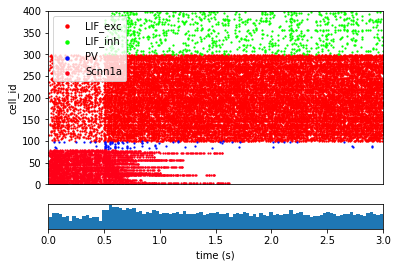

In [9]:
from bmtk.analyzer.visualization.spikes import plot_spikes, plot_rates

plot_spikes('network/V1_nodes.h5', 'network/V1_node_types.csv', 'output/spikes.h5', group_key='pop_name')

or we can plot the rates of the different populations

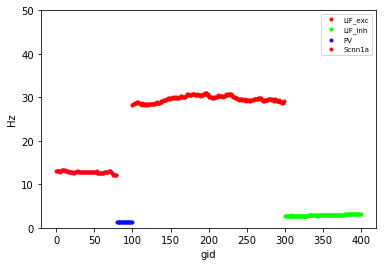

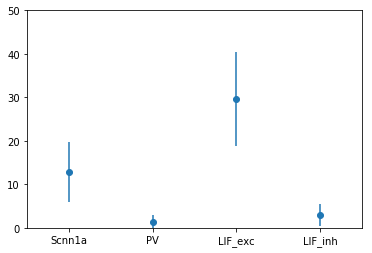

In [1]:
from bmtk.analyzer.visualization.spikes import plot_spikes, plot_rates

plot_rates('network/V1_nodes.h5', 'network/V1_node_types.csv', 'output/spikes.h5', group_key='pop_name', smoothed=True)

In our config file we used the cell_vars and node_id_selections parameters to save the calcium influx and membrane potential of selected cells. We can also use the analyzer to display these traces:

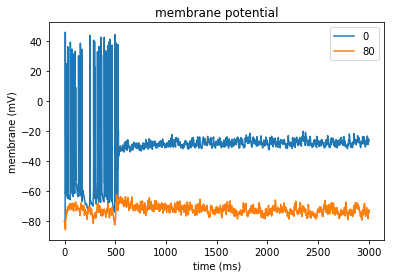

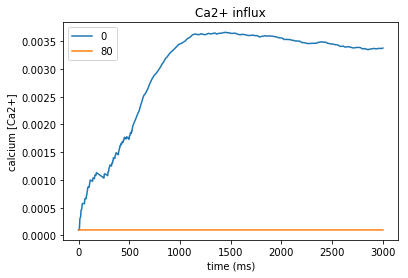

In [4]:
from bmtk.analyzer import plot_potential, plot_calcium

plot_potential(cell_vars_h5='output/cell_vars.h5', gids=[0, 80])
plot_calcium(cell_vars_h5='output/cell_vars.h5', gids=[0, 80])